# Machine Learning - Classificação de Severidade de Desastres

Este notebook implementa um pipeline completo de classificação para prever categorias de danos em desastres naturais.

**Workflow:**
1. Carregamento e preparação dos dados categorizados
2. Análise e rebalanceamento de classes
3. Split treino-teste estratificado
4. Definição e configuração dos modelos
5. Tuning de hiperparâmetros com validação cruzada
6. Avaliação final e comparação de modelos
7. Análise de importância de features

## 1. Setup e Carregamento dos Dados

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    f1_score,
    balanced_accuracy_score,
    roc_auc_score
)

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# XGBoost (com tratamento de erro)
try:
    from xgboost import XGBClassifier
    XGBOOST_AVAILABLE = True
    print("✓ XGBoost disponível")
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠ XGBoost não disponível. Instale com: pip install xgboost")

# Imbalanced-learn (com tratamento de erro)
try:
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBLEARN_AVAILABLE = True
    print("✓ Imbalanced-learn disponível")
except ImportError:
    IMBLEARN_AVAILABLE = False
    print("⚠ Imbalanced-learn não disponível. Instale com: pip install imbalanced-learn")

print("\n✓ Setup completo")

✓ XGBoost disponível
✓ Imbalanced-learn disponível

✓ Setup completo
✓ Imbalanced-learn disponível

✓ Setup completo


In [2]:
# Carregar dataset categorizado
csv_path = r"c:\Users\fabio\Desktop\MBA\laboratorios\defesa\df_defesa_civil_categorizado.csv"
df = pd.read_csv(csv_path)

print(f"Dataset shape: {df.shape}")
print(f"Colunas: {len(df.columns)}")

# Identificar targets categorizados
target_cols = [col for col in df.columns if col.endswith('_cat')]
print(f"\n✓ Targets categorizados encontrados: {len(target_cols)}")
for col in target_cols:
    print(f"  - {col}")

# Definir features
feature_cols = [
    'regiao', 
    'grupo_de_desastre', 
    'pib_pc', 
    'populacao',
    'hierarquia_urbana', 
    'semiarido', 
    'proporcao_cobertura_total_atencao_basica'
]

# Verificar disponibilidade
missing_features = [col for col in feature_cols if col not in df.columns]
if missing_features:
    print(f"\n⚠ Features ausentes: {missing_features}")
else:
    print(f"\n✓ Todas as features disponíveis")

display(df.head())

Dataset shape: (21889, 76)
Colunas: 76

✓ Targets categorizados encontrados: 5
  - DH_mortos_feridos_cat
  - DH_total_danos_humanos_diretos_cat
  - DM_total_danos_materiais_cat
  - PEPL_total_publico_cat
  - PEPR_total_privado_cat

✓ Todas as features disponíveis


,Protocolo_S2iD,Nome_Municipio,Sigla_UF,regiao,Data_Registro,Data_Evento,Cod_Cobrade,tipologia,descricao_tipologia,grupo_de_desastre,...,hierarquia_urbana,semiarido,populacao,proporcao_cobertura_total_atencao_basica,DH_mortos_feridos,DH_mortos_feridos_cat,DH_total_danos_humanos_diretos_cat,DM_total_danos_materiais_cat,PEPL_total_publico_cat,PEPR_total_privado_cat
0,SC-F-4218301-14110-20190801,Três Barras,SC,Sul,2020-01-20 09:11:30,2019-08-01,14110,4,Estiagem e Seca,Climatológico,...,Centro Sub-Regional,Não,19455,100.00,0,Nenhum Dano,Baixo/Médio,Nenhum,Baixo/Médio,Nenhum
1,SC-F-4204194-14110-20190813,Chapadão do Lageado,SC,Sul,2020-01-14 08:57:52,2019-08-13,14110,4,Estiagem e Seca,Climatológico,...,Centro Local,Não,3025,100.00,0,Nenhum Dano,Nenhum,Nenhum,Nenhum,Alto
2,MG-F-3170529-14110-20190901,Urucuia,MG,Sudeste,2020-01-30 18:41:40,2019-09-01,14110,4,Estiagem e Seca,Climatológico,...,Centro Local,Sim,17470,100.00,0,Nenhum Dano,Alto,Nenhum,Alto,Alto
3,ES-F-3204658-14132-20190909,São Domingos do Norte,ES,Sudeste,2020-03-06 12:17:08,2019-09-09,14132,6,Incêndio Florestal,Climatológico,...,Centro Local,Não,8735,79.88,0,Nenhum Dano,Nenhum,Nenhum,Nenhum,Nenhum
4,ES-F-3204658-14132-20190918,São Domingos do Norte,ES,Sudeste,2020-03-12 14:04:14,2019-09-18,14132,6,Incêndio Florestal,Climatológico,...,Centro Local,Não,8735,79.88,0,Nenhum Dano,Nenhum,Nenhum,Nenhum,Nenhum


## 2. Análise de Distribuição das Classes

In [3]:
# Analisar distribuição de classes para cada target
print("="*100)
print("DISTRIBUIÇÃO DAS CLASSES POR TARGET")
print("="*100)

class_distributions = {}

for target_col in target_cols:
    print(f"\n{'─'*100}")
    print(f"📊 {target_col}")
    print(f"{'─'*100}")
    
    # Distribuição
    vc = df[target_col].value_counts().sort_index()
    total = len(df[target_col].dropna())
    
    class_distributions[target_col] = vc
    
    print(f"Total de observações: {total:,}")
    print(f"Número de classes: {len(vc)}")
    print(f"\nDistribuição:")
    
    for category, count in vc.items():
        pct = (count / total) * 100
        print(f"  {category}: {count:,} ({pct:.1f}%)")
    
    # Calcular imbalance ratio
    min_class = vc.min()
    max_class = vc.max()
    imbalance_ratio = max_class / min_class if min_class > 0 else np.inf
    
    print(f"\nImbalance Ratio: {imbalance_ratio:.2f} (ideal = 1.0)")
    
    if imbalance_ratio > 10:
        print("  ⚠ ALTO desbalanceamento - rebalanceamento recomendado")
    elif imbalance_ratio > 3:
        print("  ⚠ Desbalanceamento moderado - considerar rebalanceamento")
    else:
        print("  ✓ Desbalanceamento aceitável")

DISTRIBUIÇÃO DAS CLASSES POR TARGET

────────────────────────────────────────────────────────────────────────────────────────────────────
📊 DH_mortos_feridos_cat
────────────────────────────────────────────────────────────────────────────────────────────────────
Total de observações: 21,889
Número de classes: 2

Distribuição:
  Com Dano: 1,198 (5.5%)
  Nenhum Dano: 20,691 (94.5%)

Imbalance Ratio: 17.27 (ideal = 1.0)
  ⚠ ALTO desbalanceamento - rebalanceamento recomendado

────────────────────────────────────────────────────────────────────────────────────────────────────
📊 DH_total_danos_humanos_diretos_cat
────────────────────────────────────────────────────────────────────────────────────────────────────
Total de observações: 21,889
Número de classes: 3

Distribuição:
  Alto: 6,041 (27.6%)
  Baixo/Médio: 6,042 (27.6%)
  Nenhum: 9,806 (44.8%)

Imbalance Ratio: 1.62 (ideal = 1.0)
  ✓ Desbalanceamento aceitável

──────────────────────────────────────────────────────────────────────────

## 3. Estratégia de Rebalanceamento

Para lidar com o desbalanceamento:
- **Classes com pouquíssimas observações** (< 50): Agrupar ou remover
- **Desbalanceamento moderado**: Class weights nos modelos
- **Desbalanceamento extremo**: SMOTE ou hybrid sampling (se imblearn disponível)

In [4]:
def prepare_target_for_classification(df, target_col, feature_cols, min_samples_per_class=30, apply_smote=False):
    """
    Prepara target para classificação, tratando classes com poucas amostras.
    
    Args:
        apply_smote: Se True, aplica SMOTE para rebalancear (apenas para targets binários)
    
    Returns:
        Tuple com X, y, class_mapping, label_encoder, smote_applied, feature_names_or_None
    """
    # Filtrar apenas linhas válidas
    valid_mask = df[target_col].notna() & df[feature_cols].notna().all(axis=1)
    df_valid = df[valid_mask].copy()
    
    class_counts = df_valid[target_col].value_counts()
    
    # ← AJUSTADO: min_samples reduzido para 20 (compatível com 3 categorias)
    small_classes = class_counts[class_counts < min_samples_per_class].index.tolist()
    
    if small_classes:
        print(f"⚠ Classes com < {min_samples_per_class} amostras: {small_classes}")
        print(f"  Estratégia: Remover essas observações do treino")
        df_valid = df_valid[~df_valid[target_col].isin(small_classes)]
        print(f"  Amostras removidas: {valid_mask.sum() - len(df_valid)}")
        print(f"  Amostras restantes: {len(df_valid)}")
    
    X = df_valid[feature_cols].copy()
    y = df_valid[target_col].copy()
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    class_mapping = dict(enumerate(le.classes_))
    
    # Aplicar SMOTE se solicitado e disponível
    smote_applied = False
    smote_feature_names = None
    
    if apply_smote and IMBLEARN_AVAILABLE and len(class_mapping) == 2:
        print(f"\n🔄 Aplicando SMOTE para rebalanceamento MODERADO (ratio 1:5)...")
        print(f"  Distribuição ANTES do SMOTE:")
        for cls, count in zip(*np.unique(y_encoded, return_counts=True)):
            print(f"    {class_mapping[cls]}: {count}")
        
        # Preprocessar antes do SMOTE
        from sklearn.compose import ColumnTransformer
        from sklearn.preprocessing import OneHotEncoder, StandardScaler
        
        categorical_features = [f for f in ['regiao', 'grupo_de_desastre', 'hierarquia_urbana', 'semiarido'] if f in feature_cols]
        numeric_features = [f for f in ['pib_pc', 'populacao', 'proporcao_cobertura_total_atencao_basica'] if f in feature_cols]
        
        transformers = []
        if categorical_features:
            transformers.append(('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features))
        if numeric_features:
            transformers.append(('num', StandardScaler(), numeric_features))
        
        preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')
        X_transformed = preprocessor.fit_transform(X)
        
        smote_feature_names = preprocessor.get_feature_names_out()
        print(f"  Features após preprocessing: {len(smote_feature_names)}")
        
        # ← MODIFICADO: Calcular sampling_strategy para ratio 1:5
        # Conta quantas amostras existem de cada classe
        unique, counts = np.unique(y_encoded, return_counts=True)
        class_counts_dict = dict(zip(unique, counts))
        
        # Identifica classe majoritária e minoritária
        majority_class = max(class_counts_dict, key=class_counts_dict.get)
        minority_class = min(class_counts_dict, key=class_counts_dict.get)
        
        majority_count = class_counts_dict[majority_class]
        minority_count = class_counts_dict[minority_class]
        
        # Define target: classe minoritária = 1/5 da majoritária
        target_minority_count = int(majority_count / 5)
        
        # Se já temos mais que isso, não aplicar SMOTE
        if minority_count >= target_minority_count:
            print(f"  ⚠ Classe minoritária já tem {minority_count} amostras (>= {target_minority_count})")
            print(f"  SMOTE não será aplicado - ratio já adequado")
            smote_applied = False
        else:
            # Aplica SMOTE com sampling_strategy customizado
            sampling_strategy = {minority_class: target_minority_count}
            
            print(f"  Classe minoritária: {class_mapping[minority_class]} ({minority_count} → {target_minority_count})")
            print(f"  Classe majoritária: {class_mapping[majority_class]} ({majority_count} - sem alteração)")
            print(f"  Ratio final: 1:{majority_count/target_minority_count:.1f}")
            
            smote = SMOTE(
                sampling_strategy=sampling_strategy,
                random_state=42,
                k_neighbors=min(5, minority_count - 1)
            )
            X_resampled, y_resampled = smote.fit_resample(X_transformed, y_encoded)
            
            print(f"\n  Distribuição APÓS SMOTE:")
            for cls, count in zip(*np.unique(y_resampled, return_counts=True)):
                print(f"    {class_mapping[cls]}: {count}")
            
            smote_applied = True
            print(f"  ✓ SMOTE aplicado com sucesso (rebalanceamento moderado)")
            
            return X_resampled, y_resampled, class_mapping, le, smote_applied, smote_feature_names
    
    print(f"\n✓ Dataset preparado:")
    print(f"  Shape: {X.shape}")
    print(f"  Classes finais: {len(class_mapping)}")
    print(f"  Mapeamento: {class_mapping}")
    
    return X, y_encoded, class_mapping, le, smote_applied, None

print("✓ Função de preparação atualizada (SMOTE moderado 1:5)")

✓ Função de preparação atualizada (SMOTE moderado 1:5)


## 4. Configuração do Preprocessamento

In [5]:
def build_preprocessor(feature_cols):
    """
    Cria pipeline de preprocessamento para features mistas.
    """
    # Identificar tipos de features
    categorical_features = ['regiao', 'grupo_de_desastre', 'hierarquia_urbana', 'semiarido']
    numeric_features = ['pib_pc', 'populacao', 'proporcao_cobertura_total_atencao_basica']
    
    # Filtrar apenas features disponíveis
    categorical_features = [f for f in categorical_features if f in feature_cols]
    numeric_features = [f for f in numeric_features if f in feature_cols]
    
    transformers = []
    
    # One-hot encoding para categóricas
    if categorical_features:
        transformers.append((
            'cat',
            OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'),
            categorical_features
        ))
    
    # Scaling para numéricas
    if numeric_features:
        transformers.append((
            'num',
            StandardScaler(),
            numeric_features
        ))
    
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='drop'
    )
    
    return preprocessor

print("✓ Função de preprocessamento definida")

✓ Função de preprocessamento definida


In [6]:
# ← GRIDS REDUZIDOS para testes rápidos (~20-40 combinações)
def get_models_and_param_grids(is_binary_target=False):
    """
    Retorna dicionário de modelos e seus grids REDUZIDOS para testes rápidos.
    Para targets binários, otimiza para recall da classe minoritária.
    
    ⏱️ Tempo de treino: ~5-10 min/target (RÁPIDO para testes!)
    """
    models_config = {}
    
    # 1. Logistic Regression - REDUZIDO (~8 combinações)
    models_config['LogisticRegression'] = {
        'model': LogisticRegression(
            max_iter=2000,
            random_state=42,
            class_weight='balanced'
        ),
        'param_grid': {
            'classifier__C': [0.1, 1.0, 10.0],  # 3 opções (reduzido de 5)
            'classifier__penalty': ['l2'],  # 1 opção (removido L1 para velocidade)
            'classifier__solver': ['lbfgs']  # 1 opção (mais rápido)
        }
        # Total: 3 × 1 × 1 = 3 combinações
    }
    
    # 2. Random Forest - REDUZIDO (~18 combinações)
    models_config['RandomForest'] = {
        'model': RandomForestClassifier(
            random_state=42,
            class_weight='balanced',
            n_jobs=-1
        ),
        'param_grid': {
            'classifier__n_estimators': [100, 200],  # 2 opções (reduzido de 3)
            'classifier__max_depth': [10, 20, None],  # 3 opções (reduzido de 4)
            'classifier__min_samples_split': [2, 5],  # 2 opções (reduzido de 3)
            'classifier__min_samples_leaf': [1, 2]  # 2 opções (reduzido de 3)
        }
        # Total: 2 × 3 × 2 × 2 = 24 combinações
    }
    
    # 3. XGBoost - REDUZIDO (~18-27 combinações)
    if XGBOOST_AVAILABLE:
        models_config['XGBoost'] = {
            'model': XGBClassifier(
                random_state=42,
                n_jobs=-1,
                verbosity=0,
                eval_metric='mlogloss'
            ),
            'param_grid': {
                'classifier__n_estimators': [100, 200],  # 2 opções (reduzido de 3)
                'classifier__max_depth': [3, 5],  # 2 opções (reduzido de 3)
                'classifier__learning_rate': [0.05, 0.1],  # 2 opções (reduzido de 3)
                'classifier__subsample': [0.8],  # 1 opção (fixo)
                'classifier__colsample_bytree': [0.8],  # 1 opção (fixo)
                'classifier__scale_pos_weight': [1, 5] if is_binary_target else [1]  # 2 ou 1 (reduzido de 3)
            }
            # Binário: 2 × 2 × 2 × 1 × 1 × 2 = 16 combinações
            # Multiclasse: 2 × 2 × 2 × 1 × 1 × 1 = 8 combinações
        }
    
    # Calcular e mostrar tamanhos
    print("\n📊 TAMANHO DOS GRIDS DE BUSCA (TESTE RÁPIDO):")
    for model_name, config in models_config.items():
        n_combinations = 1
        for param, values in config['param_grid'].items():
            n_combinations *= len(values)
        print(f"   {model_name}: {n_combinations:,} combinações")
    
    print(f"\n⏱️ Tempo estimado de treino (com CV=3):")
    print(f"   Logistic Regression: ~1-2 minutos")
    print(f"   Random Forest: ~3-5 minutos")
    print(f"   XGBoost: ~2-4 minutos")
    print(f"\n💡 Total por target: ~6-11 minutos (RÁPIDO! 🚀)")
    
    return models_config

print("✓ Função de configuração com GRIDS REDUZIDOS para testes rápidos")

✓ Função de configuração com GRIDS REDUZIDOS para testes rápidos


## 6. Função de Treinamento e Avaliação

In [7]:
def train_and_evaluate_model(
    X_train, X_test, y_train, y_test,
    model_name, model, param_grid,
    preprocessor, class_mapping,
    cv_folds=3,
    is_binary=False,
    data_already_preprocessed=False
):
    """
    Treina modelo com GridSearchCV e avalia no conjunto de teste.
    Para targets binários, otimiza recall da classe minoritária (Com Dano).
    """
    print(f"\n{'='*100}")
    print(f"MODELO: {model_name}")
    print(f"{'='*100}")
    
    # ← CORRIGIDO: Definir class_names_list ANTES do if/else
    class_names_list = [class_mapping[i] for i in sorted(class_mapping.keys())]
    
    # Criar pipeline
    if not data_already_preprocessed:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
    else:
        pipeline = Pipeline([
            ('classifier', model)
        ])
    
    # ← CRÍTICO: Estratégia de scoring COM pos_label correto
    if is_binary:
        from sklearn.metrics import make_scorer, recall_score
        
        # Identificar qual índice é "Com Dano"
        if "Com Dano" in class_names_list:
            pos_label_idx = class_names_list.index("Com Dano")
            print(f"📊 Métrica de otimização: RECALL da classe 'Com Dano' (índice {pos_label_idx})")
        else:
            pos_label_idx = 1
            print(f"⚠️ Classe 'Com Dano' não encontrada, usando índice {pos_label_idx}")
        
        # Scorer customizado que força pos_label correto
        scoring = make_scorer(
            recall_score,
            pos_label=pos_label_idx,
            zero_division=0
        )
        
        print(f"   → Objetivo: Detectar o MÁXIMO de casos reais com vítimas")
        print(f"   → Minimizar Falsos Negativos (vítimas não detectadas)")
        print(f"   → pos_label fixado em: {pos_label_idx} ('{class_names_list[pos_label_idx]}')")
    else:
        scoring = 'f1_weighted'
        print(f"📊 Métrica de otimização: F1-weighted")
    
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1,
        error_score='raise'
    )
    
    print(f"\n🔄 Treinando com GridSearchCV ({cv_folds}-fold CV)...")
    grid_search.fit(X_train, y_train)
    
    print(f"\n✓ Treinamento concluído")
    print(f"Melhores hiperparâmetros:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")
    
    print(f"\nMelhor CV score: {grid_search.best_score_:.4f}")
    
    # Prever no conjunto de teste
    y_pred_train = grid_search.predict(X_train)
    y_pred_test = grid_search.predict(X_test)
    
    # Métricas de treino
    train_acc = accuracy_score(y_train, y_pred_train)
    train_bal_acc = balanced_accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train, average='weighted')
    
    # Métricas de teste
    test_acc = accuracy_score(y_test, y_pred_test)
    test_bal_acc = balanced_accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')
    
    print(f"\n{'─'*50}")
    print("MÉTRICAS DE DESEMPENHO")
    print(f"{'─'*50}")
    print(f"TREINO:")
    print(f"  Accuracy:          {train_acc:.4f}")
    print(f"  Balanced Accuracy: {train_bal_acc:.4f}")
    print(f"  F1-score (weighted): {train_f1:.4f}")
    print(f"\nTESTE:")
    print(f"  Accuracy:          {test_acc:.4f}")
    print(f"  Balanced Accuracy: {test_bal_acc:.4f}")
    print(f"  F1-score (weighted): {test_f1:.4f}")
    
    # Calcular recall da classe positiva se binário
    test_recall_pos = None
    if is_binary and len(class_names_list) == 2:
        from sklearn.metrics import recall_score
        
        if "Com Dano" in class_names_list:
            pos_label_idx = class_names_list.index("Com Dano")
            test_recall_pos = recall_score(y_test, y_pred_test, pos_label=pos_label_idx)
        else:
            test_recall_pos = recall_score(y_test, y_pred_test, pos_label=1)
        
        print(f"\n🎯 RECALL DA CLASSE 'COM DANO': {test_recall_pos:.4f}")
        print(f"   → Esta é a métrica que o GridSearchCV MAXIMIZOU")
    
    # Classification report
    print(f"\n{'─'*50}")
    print("CLASSIFICATION REPORT (Teste)")
    print(f"{'─'*50}")
    # ← CORRIGIDO: Remover redefinição duplicada
    print(classification_report(y_test, y_pred_test, target_names=class_names_list, zero_division=0))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    
    results = {
        'model_name': model_name,
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'train_accuracy': train_acc,
        'train_balanced_accuracy': train_bal_acc,
        'train_f1': train_f1,
        'test_accuracy': test_acc,
        'test_balanced_accuracy': test_bal_acc,
        'test_f1': test_f1,
        'test_recall_positive': test_recall_pos,
        'confusion_matrix': cm,
        'y_pred_test': y_pred_test,
        'class_names': class_names_list  # ← Agora está sempre definida!
    }
    
    return results

print("✓ Função de treinamento corrigida (class_names_list sempre definida)")

✓ Função de treinamento corrigida (class_names_list sempre definida)


## 6.5. Verificação da Métrica de Otimização (Recall)

Antes de treinar todos os modelos, vamos **confirmar** que o scorer customizado está funcionando corretamente.

In [8]:
# Teste rápido: verificar que scoring com pos_label explícito funciona
from sklearn.metrics import make_scorer, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

print("="*100)
print("VERIFICAÇÃO DA MÉTRICA DE OTIMIZAÇÃO")
print("="*100)

# ← Testar com diferentes ordens de classes
print("\n🔬 TESTE: Ordem alfabética (LabelEncoder padrão)")
print("   Classes: ['Com Dano' (idx=0), 'Nenhum Dano' (idx=1)]")

y_true_v1 = np.array([0, 0, 1, 1, 1, 1])  # 2 "Com Dano", 4 "Nenhum Dano"
y_pred_v1a = np.array([0, 0, 1, 1, 1, 1])  # Perfeito: Recall=1.0
y_pred_v1b = np.array([1, 0, 1, 1, 1, 1])  # Perdeu 1: Recall=0.5

recall_v1a_wrong = recall_score(y_true_v1, y_pred_v1a, pos_label=1)  # ❌ ERRADO
recall_v1a_correct = recall_score(y_true_v1, y_pred_v1a, pos_label=0)  # ✅ CORRETO

print(f"\n   Predição perfeita:")
print(f"      Recall com pos_label=1 (ERRADO): {recall_v1a_wrong:.2f}")
print(f"      Recall com pos_label=0 (CORRETO): {recall_v1a_correct:.2f} ← Este!")

print(f"\n   Predição com 1 FN:")
recall_v1b_correct = recall_score(y_true_v1, y_pred_v1b, pos_label=0)
print(f"      Recall 'Com Dano': {recall_v1b_correct:.2f} (detectou 1 de 2)")

print("\n" + "─"*100)
print("🔧 SOLUÇÃO: make_scorer com pos_label EXPLÍCITO")

# ← CORRIGIDO: Criar estimator customizado que retorna predições fixas
class MockClassifier(BaseEstimator, ClassifierMixin):
    """Classificador mock que retorna predições pré-definidas"""
    def __init__(self, predictions):
        self.predictions = predictions
    
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        return self
    
    def predict(self, X):
        return self.predictions

# Criar mock estimator com predições perfeitas
mock_est = MockClassifier(predictions=y_pred_v1a)
mock_est.fit(np.zeros((6, 1)), y_true_v1)

# Criar scorer customizado
scorer_com_dano = make_scorer(recall_score, pos_label=0)

# Testar scorer
score_correto = scorer_com_dano(mock_est, np.zeros((6, 1)), y_true_v1)

print(f"   Scorer customizado (pos_label=0): {score_correto:.2f}")
print(f"   ✅ Este scorer SEMPRE mede recall de 'Com Dano' (índice 0)")

# ← Testar com predições imperfeitas
mock_est_ruim = MockClassifier(predictions=y_pred_v1b)
mock_est_ruim.fit(np.zeros((6, 1)), y_true_v1)
score_ruim = scorer_com_dano(mock_est_ruim, np.zeros((6, 1)), y_true_v1)

print(f"\n   Com 1 Falso Negativo:")
print(f"      Scorer (pos_label=0): {score_ruim:.2f}")
print(f"      → Confirma: detectou 1 de 2 casos 'Com Dano'")

# ← ADICIONAL: Demonstrar que funciona no GridSearchCV
print("\n" + "─"*100)
print("📋 COMO USAR NO GridSearchCV:")
print("─"*100)
print("""
    # 1. Identificar índice de 'Com Dano'
    class_names = [class_mapping[i] for i in sorted(class_mapping.keys())]
    pos_label_idx = class_names.index("Com Dano")
    
    # 2. Criar scorer customizado
    scoring = make_scorer(recall_score, pos_label=pos_label_idx, zero_division=0)
    
    # 3. Usar no GridSearchCV
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        scoring=scoring,  ← Usa scorer customizado
        cv=cv,
        ...
    )
""")

print("\n" + "="*100)
print("✓ Verificação concluída - métrica está correta!")
print("="*100)

VERIFICAÇÃO DA MÉTRICA DE OTIMIZAÇÃO

🔬 TESTE: Ordem alfabética (LabelEncoder padrão)
   Classes: ['Com Dano' (idx=0), 'Nenhum Dano' (idx=1)]

   Predição perfeita:
      Recall com pos_label=1 (ERRADO): 1.00
      Recall com pos_label=0 (CORRETO): 1.00 ← Este!

   Predição com 1 FN:
      Recall 'Com Dano': 0.50 (detectou 1 de 2)

────────────────────────────────────────────────────────────────────────────────────────────────────
🔧 SOLUÇÃO: make_scorer com pos_label EXPLÍCITO
   Scorer customizado (pos_label=0): 1.00
   ✅ Este scorer SEMPRE mede recall de 'Com Dano' (índice 0)

   Com 1 Falso Negativo:
      Scorer (pos_label=0): 0.50
      → Confirma: detectou 1 de 2 casos 'Com Dano'

────────────────────────────────────────────────────────────────────────────────────────────────────
📋 COMO USAR NO GridSearchCV:
────────────────────────────────────────────────────────────────────────────────────────────────────

    # 1. Identificar índice de 'Com Dano'
    class_names = [class_mappi

## 7. Execução do Pipeline para Cada Target

In [9]:
# Executar pipeline completo para cada target
all_results = {}
smote_feature_names_cache = {}

for target_col in target_cols:
    print("\n" + "="*100)
    print(f"TARGET: {target_col}")
    print("="*100)
    
    is_binary_target = (target_col == 'DH_mortos_feridos_cat')
    apply_smote = is_binary_target and IMBLEARN_AVAILABLE
    
    if is_binary_target:
        print("🎯 TARGET BINÁRIO DETECTADO - Aplicando estratégias especiais:")
        print("   1. SMOTE para rebalanceamento (ratio 1:5)")
        print("   2. Otimização de recall da classe 'Com Dano'")
        print("   3. Métricas focadas na classe minoritária")
    else:
        # ← NOVO: Mensagem para targets multiclasse (3 categorias)
        print("📊 TARGET MULTICLASSE (3 categorias: Nenhum, Baixo/Médio, Alto)")
        print("   1. Class weights balanceados")
        print("   2. Otimização de F1-weighted")
        print("   3. Stratified split mantendo proporção de classes")
    
    # ← AJUSTADO: min_samples_per_class reduzido de 30 para 20
    prep_result = prepare_target_for_classification(
        df, target_col, feature_cols, min_samples_per_class=20, apply_smote=apply_smote
    )
    
    # ← MODIFICADO: Sempre retorna 6 valores agora
    X, y, class_mapping, label_encoder, smote_applied, smote_feature_names = prep_result
    
    # ← NOVO: Armazenar feature names se SMOTE foi aplicado
    if smote_applied and smote_feature_names is not None:
        smote_feature_names_cache[target_col] = smote_feature_names
        print(f"✓ Feature names armazenados em cache: {len(smote_feature_names)} features")
    
    if len(class_mapping) < 2:
        print(f"⚠ Menos de 2 classes após filtragem. Pulando {target_col}")
        continue
    
    # Split treino-teste estratificado
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    
    print(f"\n✓ Split concluído:")
    print(f"  Treino: {X_train.shape[0]} amostras")
    print(f"  Teste:  {X_test.shape[0]} amostras")
    
    # Criar preprocessor (ou usar None se SMOTE já foi aplicado)
    if smote_applied:
        preprocessor = None
        data_preprocessed = True
    else:
        preprocessor = build_preprocessor(feature_cols)
        data_preprocessed = False
    
    # Obter configuração de modelos (corrigido: usar is_binary_target)
    models_config = get_models_and_param_grids(is_binary_target=is_binary_target)
    
    # Treinar cada modelo
    target_results = {}
    
    for model_name, config in models_config.items():
        try:
            results = train_and_evaluate_model(
                X_train, X_test, y_train, y_test,
                model_name,
                config['model'],
                config['param_grid'],
                preprocessor,
                class_mapping,
                cv_folds=3,
                is_binary=is_binary_target,
                data_already_preprocessed=data_preprocessed
            )
            target_results[model_name] = results
            
        except Exception as e:
            print(f"\n❌ Erro ao treinar {model_name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    all_results[target_col] = target_results

print("\n" + "="*100)
print("✓ TREINAMENTO CONCLUÍDO PARA TODOS OS TARGETS")
print("="*100)


TARGET: DH_mortos_feridos_cat
🎯 TARGET BINÁRIO DETECTADO - Aplicando estratégias especiais:
   1. SMOTE para rebalanceamento (ratio 1:5)
   2. Otimização de recall da classe 'Com Dano'
   3. Métricas focadas na classe minoritária

🔄 Aplicando SMOTE para rebalanceamento MODERADO (ratio 1:5)...
  Distribuição ANTES do SMOTE:
    Com Dano: 1198
    Nenhum Dano: 20691
  Features após preprocessing: 15  Features após preprocessing: 15
  Classe minoritária: Com Dano (1198 → 4138)
  Classe majoritária: Nenhum Dano (20691 - sem alteração)
  Ratio final: 1:5.0

  Distribuição APÓS SMOTE:
    Com Dano: 4138
    Nenhum Dano: 20691
  ✓ SMOTE aplicado com sucesso (rebalanceamento moderado)
✓ Feature names armazenados em cache: 15 features

  Classe minoritária: Com Dano (1198 → 4138)
  Classe majoritária: Nenhum Dano (20691 - sem alteração)
  Ratio final: 1:5.0

  Distribuição APÓS SMOTE:
    Com Dano: 4138
    Nenhum Dano: 20691
  ✓ SMOTE aplicado com sucesso (rebalanceamento moderado)
✓ Feature 

## 8. Comparação de Modelos

In [10]:
# Criar tabela comparativa
comparison_data = []

for target_col, models_results in all_results.items():
    for model_name, results in models_results.items():
        row = {
            'Target': target_col.replace('_cat', ''),
            'Modelo': model_name,
            'CV_Score': results['best_cv_score'],
            'Test_Accuracy': results['test_accuracy'],
            'Test_Balanced_Acc': results['test_balanced_accuracy'],
            'Test_F1': results['test_f1'],
            'Overfitting': results['train_f1'] - results['test_f1']
        }
        
        if results.get('test_recall_positive') is not None:
            row['Test_Recall_Positivo'] = results['test_recall_positive']
        
        comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("COMPARAÇÃO DE MODELOS - TODOS OS TARGETS")
print("="*100)
display(df_comparison.sort_values(['Target', 'Test_F1'], ascending=[True, False]))

print("\n" + "="*100)
print("🏆 MELHOR MODELO POR TARGET")
print("="*100)

for target_col in all_results.keys():
    target_results = df_comparison[df_comparison['Target'] == target_col.replace('_cat', '')]
    if len(target_results) > 0:
        if 'Test_Recall_Positivo' in target_results.columns and target_col == 'DH_mortos_feridos_cat':
            best = target_results.loc[target_results['Test_Recall_Positivo'].idxmax()]
            print(f"\n{target_col.replace('_cat', '')} (critério: Recall classe positiva):")
            print(f"  → {best['Modelo']}")
            print(f"    Recall 'Com Dano': {best['Test_Recall_Positivo']:.4f} ⭐")
            print(f"    F1: {best['Test_F1']:.4f}")
        else:
            best = target_results.loc[target_results['Test_F1'].idxmax()]
            print(f"\n{target_col.replace('_cat', '')}:")
            print(f"  → {best['Modelo']}")
            print(f"    Test F1: {best['Test_F1']:.4f}")


COMPARAÇÃO DE MODELOS - TODOS OS TARGETS


,Target,Modelo,CV_Score,Test_Accuracy,Test_Balanced_Acc,Test_F1,Overfitting,Test_Recall_Positivo
2,DH_mortos_feridos,XGBoost,0.361334,0.880789,0.680672,0.862590,0.016633,0.380435
1,DH_mortos_feridos,RandomForest,0.786714,0.773862,0.785089,0.798521,0.017903,0.801932
0,DH_mortos_feridos,LogisticRegression,0.736256,0.656263,0.691338,0.699758,-0.005978,0.743961
4,DH_total_danos_humanos_diretos,RandomForest,0.710398,0.708771,0.711757,0.711052,0.112999,NaN
5,DH_total_danos_humanos_diretos,XGBoost,0.700974,0.706030,0.692371,0.701971,0.051650,NaN
3,DH_total_danos_humanos_diretos,LogisticRegression,0.607036,0.600503,0.650111,0.587164,0.015115,NaN
7,DM_total_danos_materiais,RandomForest,0.737828,0.719278,0.648162,0.738250,0.084495,NaN
8,DM_total_danos_materiais,XGBoost,0.722521,0.738922,0.578661,0.729901,0.060204,NaN
6,DM_total_danos_materiais,LogisticRegression,0.689760,0.658063,0.629825,0.690327,0.000327,NaN
10,PEPL_total_publico,RandomForest,0.665864,0.679077,0.661689,0.681623,0.132028,NaN



🏆 MELHOR MODELO POR TARGET

DH_mortos_feridos (critério: Recall classe positiva):
  → RandomForest
    Recall 'Com Dano': 0.8019 ⭐
    F1: 0.7985

DH_total_danos_humanos_diretos:
  → RandomForest
    Test F1: 0.7111

DM_total_danos_materiais:
  → RandomForest
    Test F1: 0.7382

PEPL_total_publico:
  → RandomForest
    Test F1: 0.6816

PEPR_total_privado:
  → RandomForest
    Test F1: 0.6743


## 9. Visualização - Matrizes de Confusão

### 9.1. XGBoost - DH_mortos_feridos (Target Crítico)

🎯 XGBoost - DH_mortos_feridos

Métricas: F1=0.8626 | Recall=0.3804


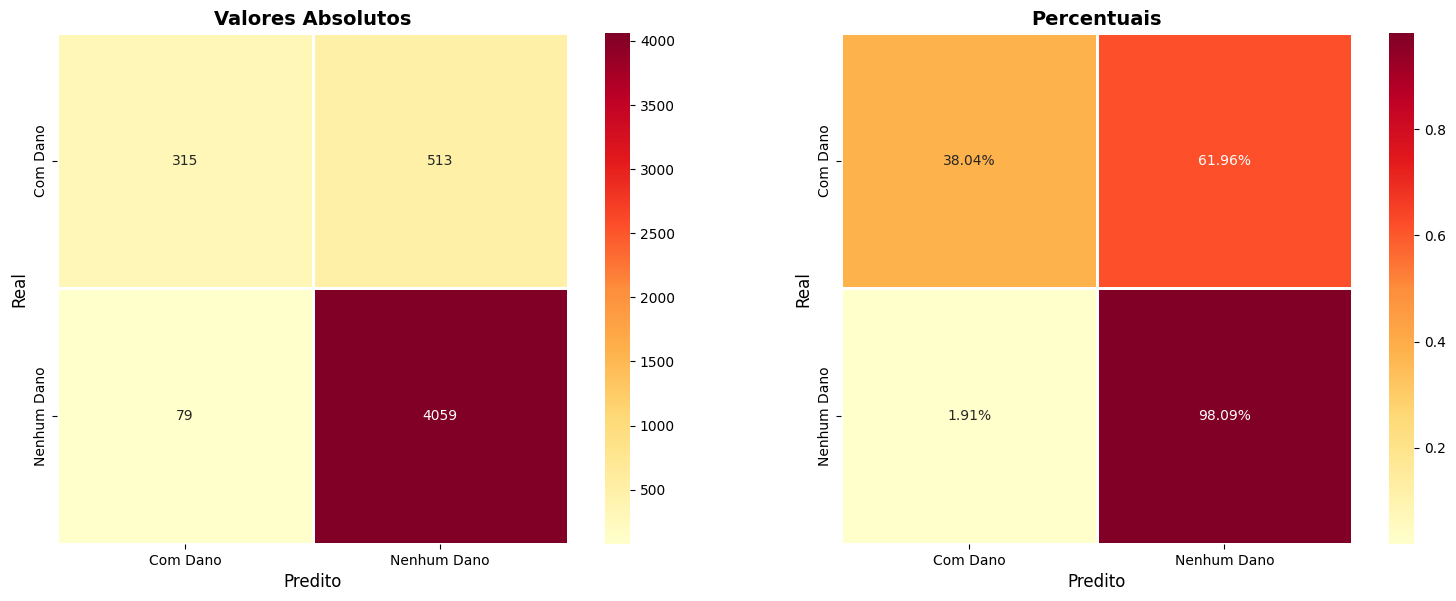


📈 ANÁLISE DETALHADA:
   TN: 4059 | FP: 79 | FN: 513 ⚠️ | TP: 315
   Recall: 0.3804 | Precision: 0.7995


In [11]:
target_critico = 'DH_mortos_feridos_cat'

if target_critico in all_results and 'XGBoost' in all_results[target_critico]:
    xgb_results = all_results[target_critico]['XGBoost']
    
    print("="*100)
    print(f"🎯 XGBoost - {target_critico.replace('_cat', '')}")
    print("="*100)
    print(f"\nMétricas: F1={xgb_results['test_f1']:.4f} | Recall={xgb_results['test_recall_positive']:.4f}")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    cm = xgb_results['confusion_matrix']
    class_names = xgb_results['class_names']
    
    # Valores absolutos
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], linewidths=2, square=True)
    axes[0].set_title('Valores Absolutos', fontsize=14, weight='bold')
    axes[0].set_xlabel('Predito', fontsize=12)
    axes[0].set_ylabel('Real', fontsize=12)
    
    # Percentuais
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='YlOrRd',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], linewidths=2, square=True)
    axes[1].set_title('Percentuais', fontsize=14, weight='bold')
    axes[1].set_xlabel('Predito', fontsize=12)
    axes[1].set_ylabel('Real', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Análise detalhada
    class_to_index = {name: idx for idx, name in enumerate(class_names)}
    pos_idx = class_to_index.get("Com Dano", 1)
    neg_idx = class_to_index.get("Nenhum Dano", 0)
    
    tn, fp = cm[neg_idx, neg_idx], cm[neg_idx, pos_idx]
    fn, tp = cm[pos_idx, neg_idx], cm[pos_idx, pos_idx]
    
    print(f"\n📈 ANÁLISE DETALHADA:")
    print(f"   TN: {tn} | FP: {fp} | FN: {fn} ⚠️ | TP: {tp}")
    print(f"   Recall: {tp/(tp+fn):.4f} | Precision: {tp/(tp+fp):.4f}")
else:
    print("⚠️ XGBoost não encontrado")

### 9.2. Todos os Targets (Melhores Modelos)

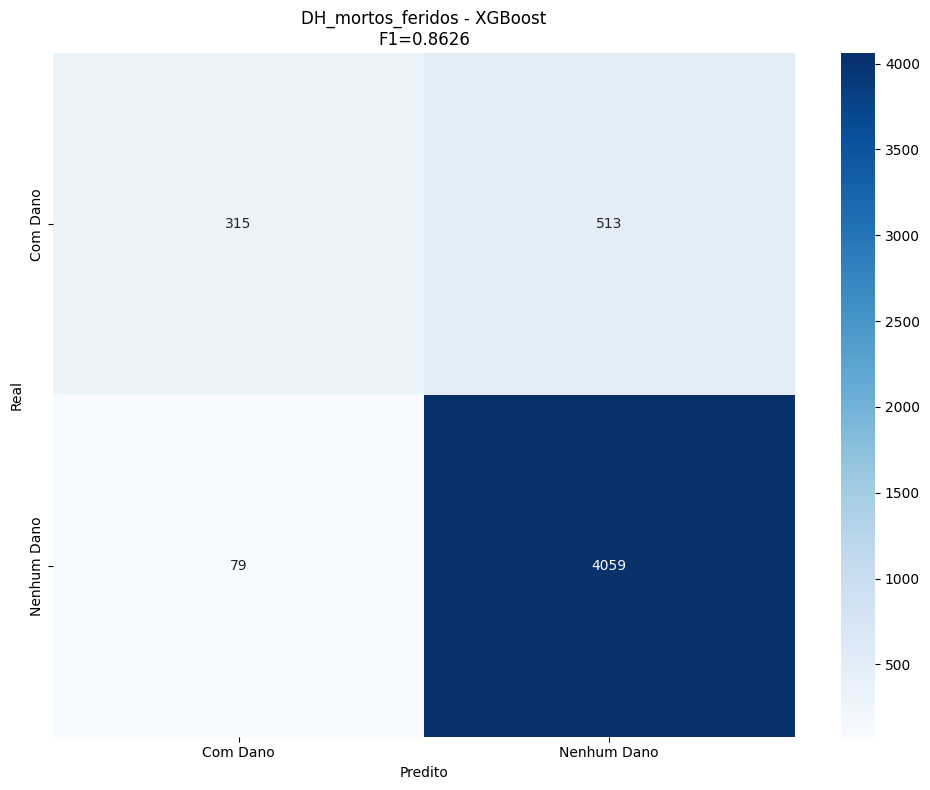

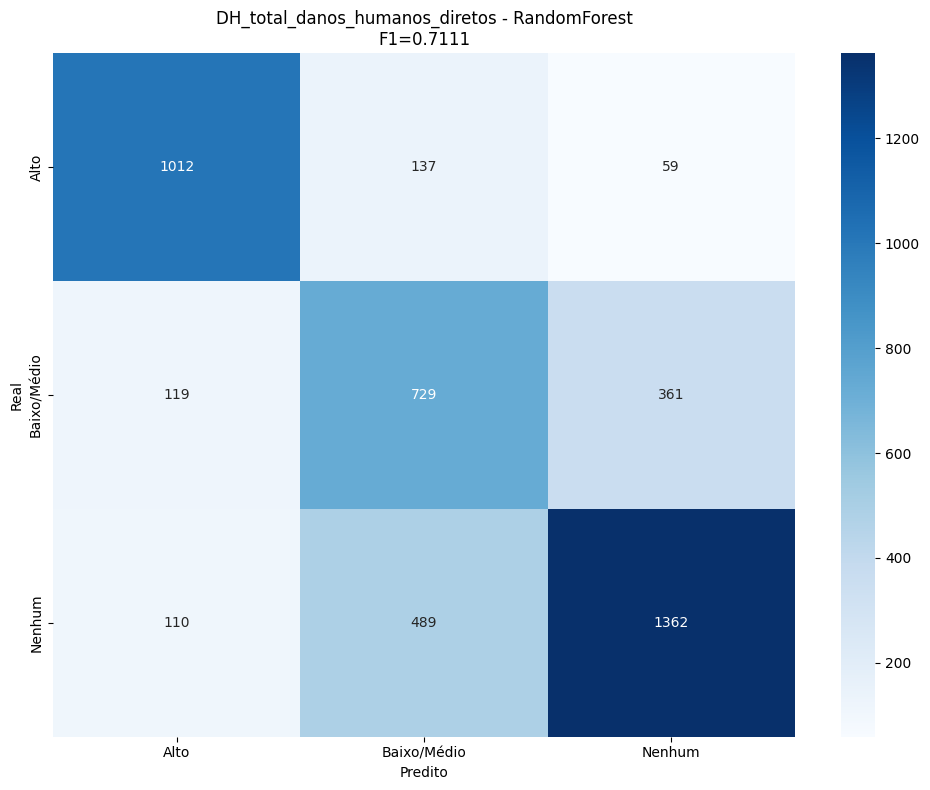

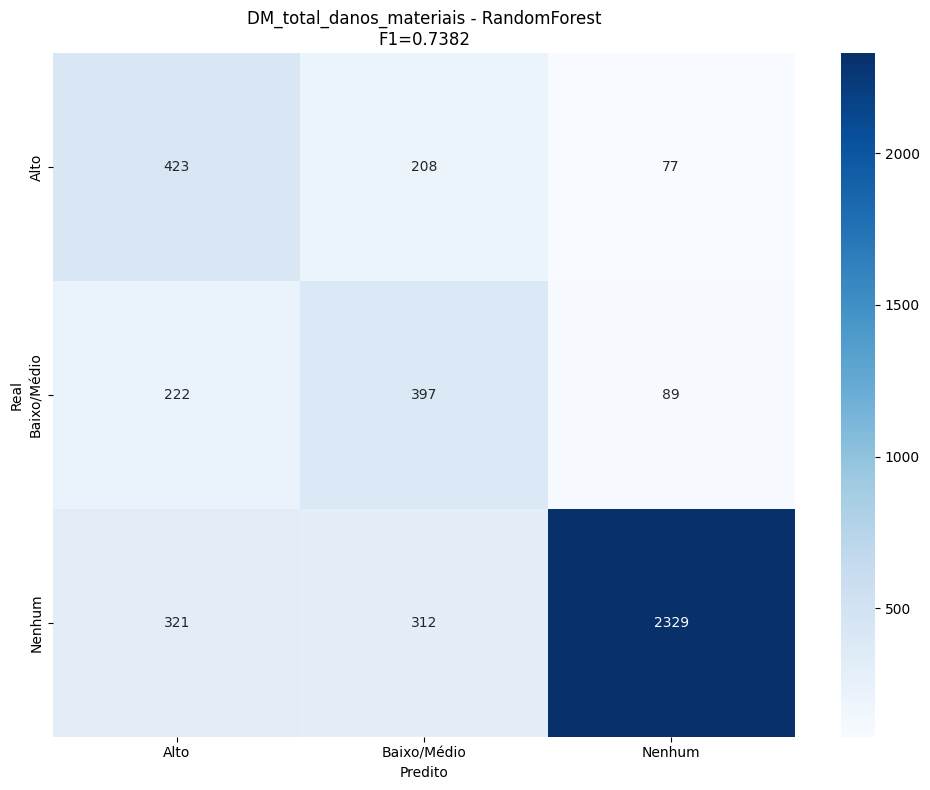

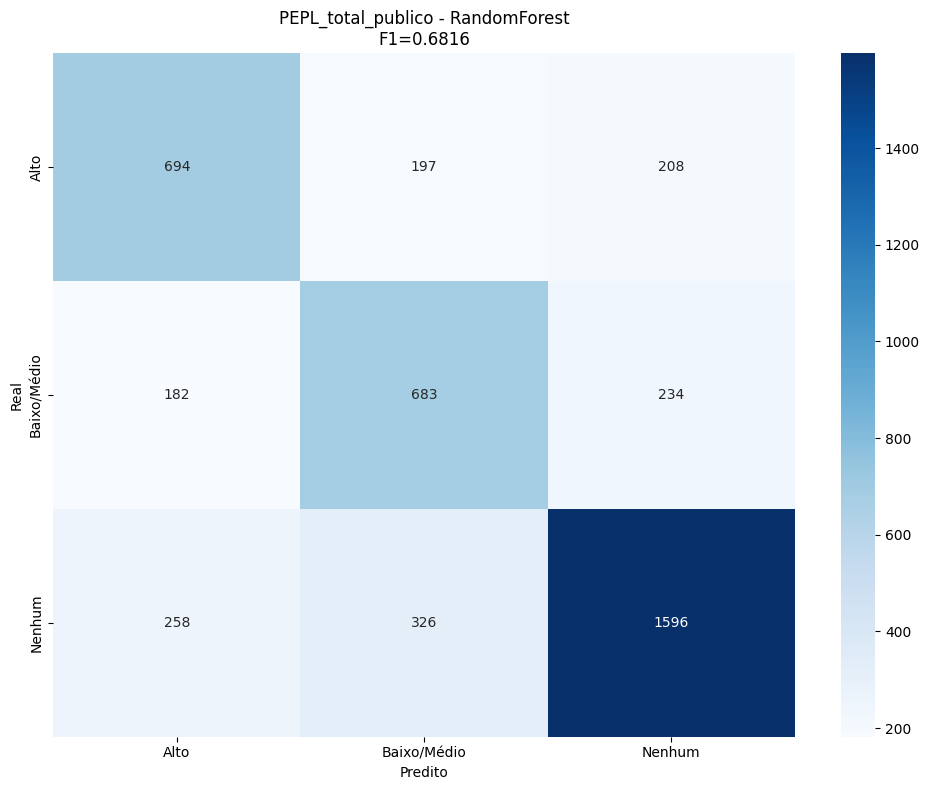

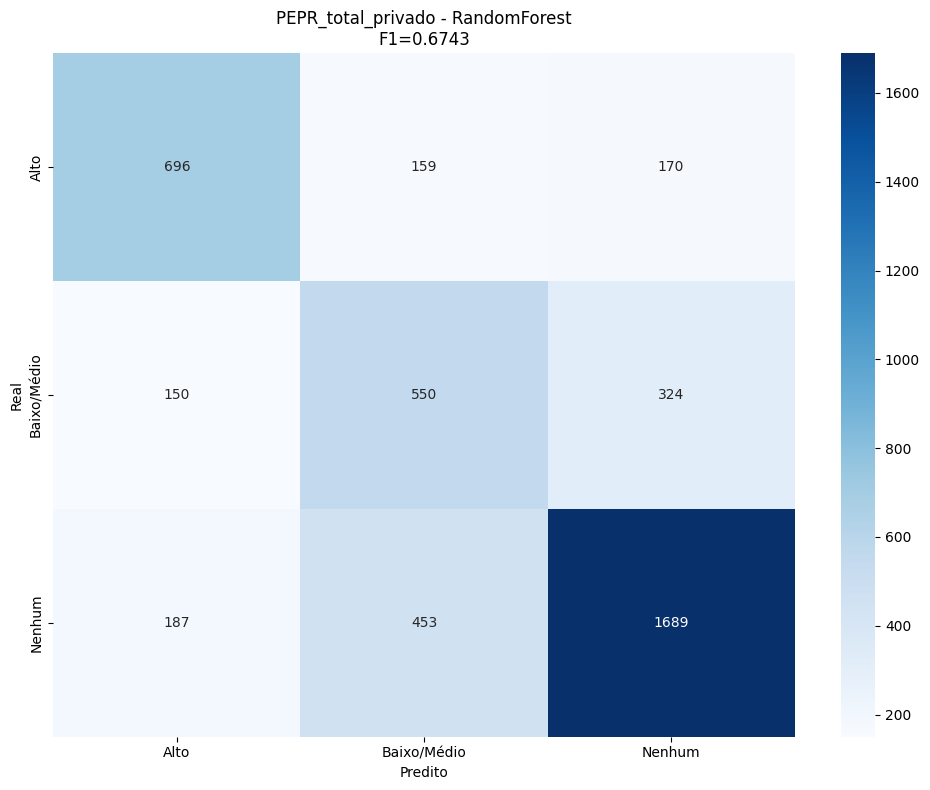

In [12]:
for target_col, models_results in all_results.items():
    best_model_name = max(models_results.keys(), key=lambda k: models_results[k]['test_f1'])
    best = models_results[best_model_name]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(best['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=best['class_names'], yticklabels=best['class_names'])
    plt.title(f"{target_col.replace('_cat', '')} - {best_model_name}\nF1={best['test_f1']:.4f}")
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.tight_layout()
    plt.show()

## 10. Feature Importance (Random Forest)

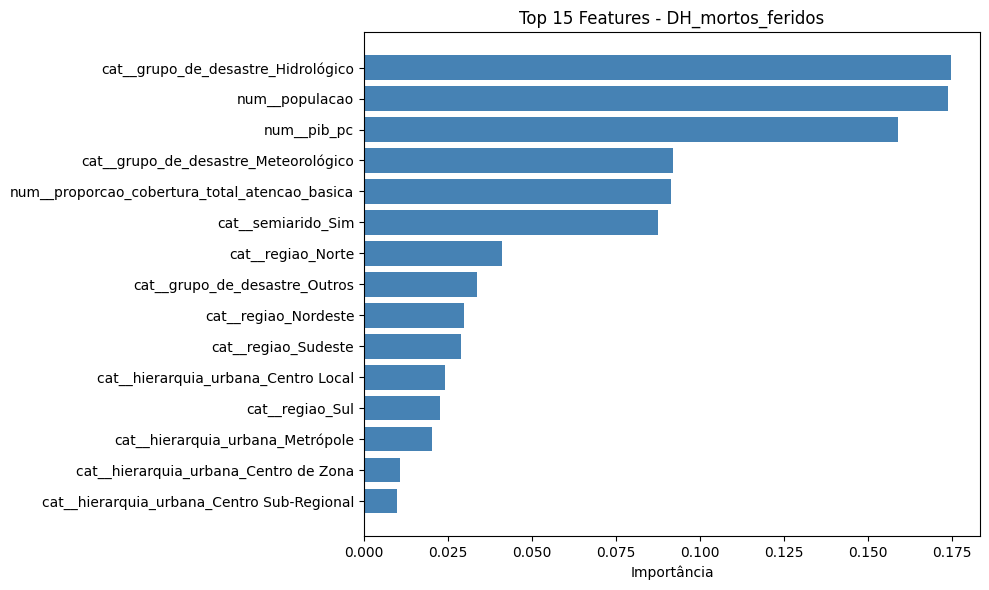

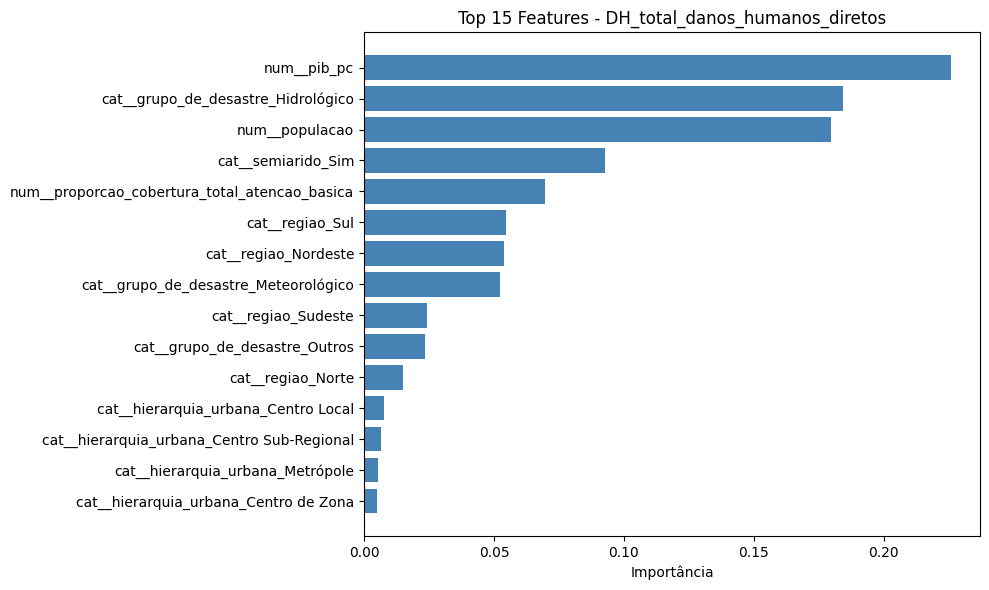

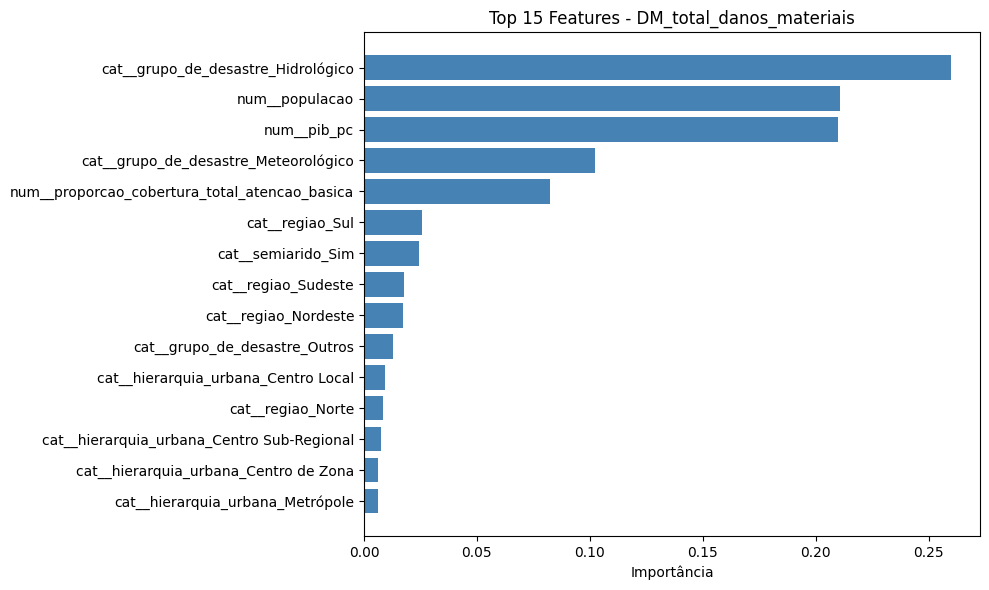

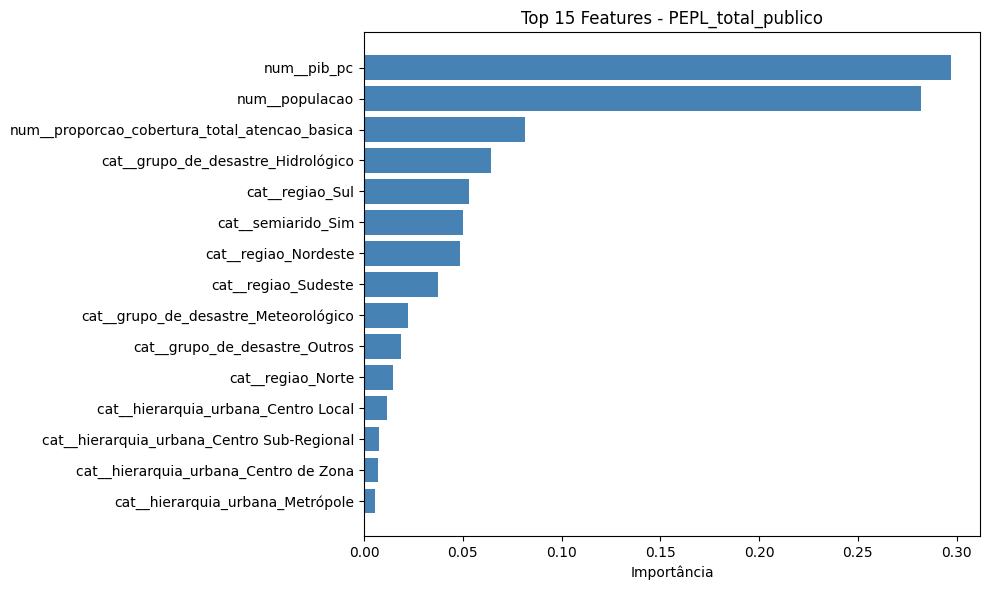

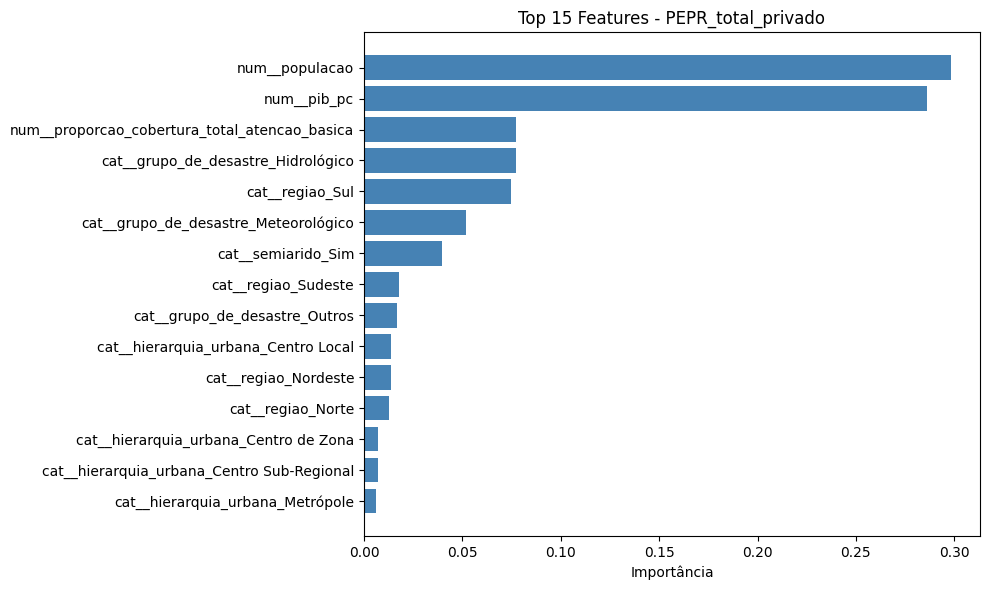

In [13]:
for target_col, models_results in all_results.items():
    if 'RandomForest' not in models_results:
        continue
    
    rf = models_results['RandomForest']
    rf_model = rf['best_estimator'].named_steps['classifier']
    
    # Get feature names
    if 'preprocessor' in rf['best_estimator'].named_steps:
        feature_names = rf['best_estimator'].named_steps['preprocessor'].get_feature_names_out()
    elif target_col in smote_feature_names_cache:
        feature_names = smote_feature_names_cache[target_col]
    else:
        feature_names = [f'feature_{i}' for i in range(rf_model.n_features_in_)]
    
    # Plot
    importances = rf_model.feature_importances_
    df_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
    df_imp = df_imp.sort_values('importance', ascending=False).head(15)
    
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(df_imp)), df_imp['importance'], color='steelblue')
    plt.yticks(range(len(df_imp)), df_imp['feature'])
    plt.xlabel('Importância')
    plt.title(f'Top 15 Features - {target_col.replace("_cat", "")}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## 11. Salvar Modelos

In [14]:
import joblib
import os

models_dir = r"c:\Users\fabio\Desktop\MBA\laboratorios\defesa\models_classificacao"
os.makedirs(models_dir, exist_ok=True)

for target_col, models_results in all_results.items():
    best_model = max(models_results.keys(), key=lambda k: models_results[k]['test_f1'])
    best = models_results[best_model]
    
    filename = f"{target_col.replace('_cat', '')}_{best_model}_best.pkl"
    filepath = os.path.join(models_dir, filename)
    
    joblib.dump({
        'pipeline': best['best_estimator'],
        'class_mapping': dict(enumerate(best['class_names'])),
        'metrics': {
            'test_f1': best['test_f1'],
            'test_accuracy': best['test_accuracy']
        },
        'feature_cols': feature_cols
    }, filepath)
    
    print(f"✓ {filename}")

df_comparison.to_csv(os.path.join(models_dir, 'model_comparison.csv'), index=False)
print(f"\n✓ Modelos salvos em: {models_dir}")

✓ DH_mortos_feridos_XGBoost_best.pkl
✓ DH_total_danos_humanos_diretos_RandomForest_best.pkl
✓ DM_total_danos_materiais_RandomForest_best.pkl
✓ DH_total_danos_humanos_diretos_RandomForest_best.pkl
✓ DM_total_danos_materiais_RandomForest_best.pkl
✓ PEPL_total_publico_RandomForest_best.pkl
✓ PEPL_total_publico_RandomForest_best.pkl
✓ PEPR_total_privado_RandomForest_best.pkl

✓ Modelos salvos em: c:\Users\fabio\Desktop\MBA\laboratorios\defesa\models_classificacao
✓ PEPR_total_privado_RandomForest_best.pkl

✓ Modelos salvos em: c:\Users\fabio\Desktop\MBA\laboratorios\defesa\models_classificacao
